In [ ]:
#import the relevant packages
import numpy as np
import tensorflow as tf
import tensorflow.contrib as tf_contrib
import os
import glob
import matplotlib.pyplot as plt
import imageio
import time
from  skimage import color
import re
import cv2
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import nn_ops
import natsort

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#define the SSIM loss function (Extracted from the tensorflow implementation)

def convert_image_dtype(
    image,
    dtype,
    saturate=False,
    name=None,
    ):

    image = ops.convert_to_tensor(image, name='image')
    if dtype == image.dtype:
        return array_ops.identity(image, name=name)

    with ops.name_scope(name, 'convert_image', [image]) as name:
        if image.dtype.is_integer and dtype.is_integer:
            scale_in = image.dtype.max
            scale_out = dtype.max
            if scale_in > scale_out:
                scale = (scale_in + 1) // (scale_out + 1)
                scaled = math_ops.div(image, scale)
                if saturate:
                    return math_ops.saturate_cast(scaled, dtype,
                            name=name)
                else:
                    return math_ops.cast(scaled, dtype, name=name)
            else:
                if saturate:
                    cast = math_ops.saturate_cast(image, dtype)
                else:
                    cast = math_ops.cast(image, dtype)
                scale = (scale_out + 1) // (scale_in + 1)
                return math_ops.multiply(cast, scale, name=name)
        elif image.dtype.is_floating and dtype.is_floating:
            return math_ops.cast(image, dtype, name=name)
        else:
            if image.dtype.is_integer:
                cast = math_ops.cast(image, dtype)
                scale = 1. / image.dtype.max
                return math_ops.multiply(cast, scale, name=name)
            else:
                scale = dtype.max + 0.5  # avoid rounding problems in the cast
                scaled = math_ops.multiply(image, scale)
                if saturate:
                    return math_ops.saturate_cast(scaled, dtype,
                            name=name)
                else:
                    return math_ops.cast(scaled, dtype, name=name)

def _verify_compatible_image_shapes(img1, img2):
    shape1 = img1.get_shape().with_rank_at_least(3)
    shape2 = img2.get_shape().with_rank_at_least(3)
    shape1[-3:].assert_is_compatible_with(shape2[-3:])

    if shape1.ndims is not None and shape2.ndims is not None:
        for (dim1, dim2) in zip(reversed(shape1[:-3]),
                                reversed(shape2[:-3])):
            if not (dim1 == 1 or dim2 == 1
                    or dim1.is_compatible_with(dim2)):
                raise ValueError('Two images are not compatible: %s and %s'
                                  % (shape1, shape2))

    (shape1, shape2) = array_ops.shape_n([img1, img2])
    checks = []
    checks.append(control_flow_ops.Assert(math_ops.greater_equal(array_ops.size(shape1),
                  3), [shape1, shape2], summarize=10))
    checks.append(control_flow_ops.Assert(math_ops.reduce_all(math_ops.equal(shape1[-3:],
                  shape2[-3:])), [shape1, shape2], summarize=10))
    return (shape1, shape2, checks)

_SSIM_K1 = 0.01
_SSIM_K2 = 0.03

def _ssim_helper(
    x,
    y,
    reducer,
    max_val,
    alpha,
    beta_gamma,
    compensation=1.0,
    ):

    c1 = (_SSIM_K1 * max_val) ** 2
    c2 = (_SSIM_K2 * max_val) ** 2
    mean0 = reducer(x)
    mean1 = reducer(y)
    num0 = mean0 * mean1 * 2.0
    den0 = math_ops.square(mean0) + math_ops.square(mean1)
    luminance = (num0 + c1) / (den0 + c1)
    luminance = luminance ** alpha
    num1 = reducer(x * y) * 2.0
    den1 = reducer(math_ops.square(x) + math_ops.square(y))
    c2 *= compensation
    cs = (num1 - num0 + c2) / (den1 - den0 + c2)
    cs = cs ** beta_gamma
    return (luminance, cs)


def _fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function."""

    size = ops.convert_to_tensor(size, dtypes.int32)
    sigma = ops.convert_to_tensor(sigma)
    coords = math_ops.cast(math_ops.range(size), sigma.dtype)
    coords -= math_ops.cast(size - 1, sigma.dtype) / 2.0
    g = math_ops.square(coords)
    g *= -0.5 / math_ops.square(sigma)
    g = array_ops.reshape(g, shape=[1, -1]) + array_ops.reshape(g,
            shape=[-1, 1])
    g = array_ops.reshape(g, shape=[1, -1])  # For tf.nn.softmax().
    g = nn_ops.softmax(g)
    return array_ops.reshape(g, shape=[size, size, 1, 1])



def _ssim_per_channel(img1, img2, alpha, beta_gamma, max_val=1.0):
    filter_size = constant_op.constant(11, dtype=dtypes.int32)
    filter_sigma = constant_op.constant(1.5, dtype=img1.dtype)

    (shape1, shape2) = array_ops.shape_n([img1, img2])
    checks =         [control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(shape1[-3:-1],
         filter_size)), [shape1, filter_size], summarize=8),
         control_flow_ops.Assert(math_ops.reduce_all(math_ops.greater_equal(shape2[-3:-1],
         filter_size)), [shape2, filter_size], summarize=8)]
    with ops.control_dependencies(checks):
        img1 = array_ops.identity(img1)
    kernel = _fspecial_gauss(filter_size, filter_sigma)
    kernel = array_ops.tile(kernel, multiples=[1, 1, shape1[-1], 1])

    compensation = 1.0
    def reducer(x):
        shape = array_ops.shape(x)
        x = array_ops.reshape(x, shape=array_ops.concat([[-1],
                              shape[-3:]], 0))
        y = nn.depthwise_conv2d(x, kernel, strides=[1, 1, 1, 1],
                                padding='VALID')
        return array_ops.reshape(y, array_ops.concat([shape[:-3],
                                 array_ops.shape(y)[1:]], 0))

    (luminance, cs) = _ssim_helper(img1, img2, reducer, max_val, alpha, beta_gamma,
                                   compensation)
    axes = constant_op.constant([-3, -2], dtype=dtypes.int32)
    ssim_val = math_ops.reduce_mean(luminance * cs, axes)
    cs = math_ops.reduce_mean(cs, axes)
    return (ssim_val, cs)


def ssim(img1, img2, alpha, beta_gamma, max_val):
    (_, _, checks) = _verify_compatible_image_shapes(img1, img2)
    with ops.control_dependencies(checks):
        img1 = array_ops.identity(img1)
    max_val = math_ops.cast(max_val, img1.dtype)
    max_val = convert_image_dtype(max_val, dtypes.float32)
    img1 = convert_image_dtype(img1, dtypes.float32)
    img2 = convert_image_dtype(img2, dtypes.float32)
    (ssim_per_channel, _) = _ssim_per_channel(img1, img2, alpha, beta_gamma, max_val)

  # Compute average over color channels.
    return math_ops.reduce_mean(ssim_per_channel, [-1])

In [ ]:
#define hyper parameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 1
epoch = 200
lr = 0.0002
lamda = 0.8

In [ ]:
#load and preprocess the training MRI images
filenames = os.listdir('/content/drive/My Drive/Training/MRI/')
dataset = os.path.join(os.getcwd(), '/content/drive/My Drive/Training/MRI/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    train_mri[i,:,:] =(imageio.imread(data[i]))
    train_mri[i,:,:] =(train_mri[i,:,:] - np.min(train_mri[i,:,:])) / (np.max(train_mri[i,:,:]) - np.min(train_mri[i,:,:]))
    train_mri[i,:,:] = np.float32(train_mri[i,:,:])

In [ ]:
#align the number of channels as per the tensorflow benchmark
train_mri = train_mri[:,:,:,np.newaxis]

In [ ]:
#load and preprocess the training PET images
filenames = os.listdir('/content/drive/My Drive/Training/PET/')
dataset = os.path.join(os.getcwd(), '/content/drive/My Drive/Training/PET/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_other = np.zeros((len(data),image_width,image_length,pet_channels),dtype=float)
train_pet = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
    train_other[i,:,:,:] =(imageio.imread(data[i]))
    train_pet[i,:,:] = 0.2989 * train_other[i,:,:,0] + 0.5870 *  train_other[i,:,:,1]  + 0.1140 * train_other[i,:,:,2]
    train_pet[i,:,:] =(train_pet[i,:,:] - np.min(train_pet[i,:,:])) / (np.max(train_pet[i,:,:]) - np.min(train_pet[i,:,:]))

In [ ]:
#align the number of channels as per the tensorflow benchmark
train_pet = train_pet[:,:,:,np.newaxis]

In [ ]:
#define placeholders for input modalities
images_pet   = tf.placeholder(tf.float32, [None, image_width,image_length,gray_channels],name='images_pet')
images_mri   = tf.placeholder(tf.float32, [None, image_width,image_length,gray_channels],name ='images_mri')


In [ ]:
#define the  FunFuseAn network
def network(pet_image, mri_image):
    with tf.variable_scope('network'):
        ######feature extraction layers######
        
        ###low frequency MRI layer###
        with tf.variable_scope('mri_lf_layer1'):
            weights=tf.get_variable("w_mri_lf_1",[9,9,1,16],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_mri_lf_1",[16],initializer=tf.constant_initializer(0.0))
            conv1= tf.contrib.layers.batch_norm(tf.nn.conv2d(mri_image, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv1 = tf.maximum(conv1, 0.2 * conv1) #Leaky RELU
            
        ###low frequency PET layer###
        with tf.variable_scope('pet_lf_layer1'):
            weights=tf.get_variable("w_pet_lf_1",[7,7,1,16],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_pet_lf_1",[16],initializer=tf.constant_initializer(0.0))
            conv2= tf.contrib.layers.batch_norm(tf.nn.conv2d(pet_image, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv2 = tf.maximum(conv2, 0.2 * conv2) #Leaky RELU  
           
        ###high frequency MRI layer 1 ###
        with tf.variable_scope('mri_hf_layer1'):
            weights=tf.get_variable("w_mri_hf_1",[3,3,1,16],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_mri_hf_1",[16],initializer=tf.constant_initializer(0.0))
            conv3= tf.contrib.layers.batch_norm(tf.nn.conv2d(mri_image, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv3 = tf.maximum(conv3, 0.2 * conv3) #Leaky RELU
            
        ###high frequency PET layer 1 ###
        with tf.variable_scope('pet_hf_layer1'):
            weights=tf.get_variable("w_pet_hf_1",[5,5,1,16],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_pet_hf_1",[16],initializer=tf.constant_initializer(0.0))
            conv4= tf.contrib.layers.batch_norm(tf.nn.conv2d(pet_image, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv4 = tf.maximum(conv4, 0.2 * conv4) #Leaky RELU        
            
        ####high frequency MRI layer 2 ###
        with tf.variable_scope('mri_hf_layer2'):
            weights=tf.get_variable("w_mri_hf_2",[3,3,16,32],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_mri_hf_2",[32],initializer=tf.constant_initializer(0.0))
            conv5= tf.contrib.layers.batch_norm(tf.nn.conv2d(conv3, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv5 = tf.maximum(conv5, 0.2 * conv5) #Leaky RELU
            
        ###high frequency PET layer 2 ###
        with tf.variable_scope('pet_hf_layer2'):
            weights=tf.get_variable("w_pet_hf_2",[5,5,16,32],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_pet_hf_2",[32],initializer=tf.constant_initializer(0.0))
            conv6= tf.contrib.layers.batch_norm(tf.nn.conv2d(conv4, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv6 = tf.maximum(conv6, 0.2 * conv6) #Leaky RELU
            
        ###high frequency MRI layer 3 ###
        with tf.variable_scope('mri_hf_layer3'):
            weights=tf.get_variable("w_mri_hf_3",[3,3,32,64],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_mri_hf_3",[64],initializer=tf.constant_initializer(0.0))
            conv7= tf.contrib.layers.batch_norm(tf.nn.conv2d(conv5, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv7 = tf.maximum(conv7, 0.2 * conv7) #Leaky RELU
            
        ###high frequency PET layer 3 ###
        with tf.variable_scope('pet_hf_layer3'):
            weights=tf.get_variable("w_pet_hf_3",[3,3,32,64],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_pet_hf_3",[64],initializer=tf.constant_initializer(0.0))
            conv8= tf.contrib.layers.batch_norm(tf.nn.conv2d(conv6, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            conv8 = tf.maximum(conv8, 0.2 * conv8) #Leaky RELU
        
        ######1st Fusion rule: High frequency######
        fused_hf_features = tf.maximum(conv7, conv8) / (conv7 + conv8)
        
        ######reconstruction layer 1######
        with tf.variable_scope('recon_layer1'):
            weights=tf.get_variable("w_recon_1",[5,5,64,32],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_recon_1",[32],initializer=tf.constant_initializer(0.0))
            recon1= tf.contrib.layers.batch_norm(tf.nn.conv2d(fused_hf_features, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            recon1 = tf.maximum(recon1, 0.2 * recon1) #Leaky RELU
            
        ######reconstruction layer 2######
        with tf.variable_scope('recon_layer2'):
            weights=tf.get_variable("w_recon_2",[5,5,32,16],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias=tf.get_variable("b_recon_2",[16],initializer=tf.constant_initializer(0.0))
            recon2= tf.contrib.layers.batch_norm(tf.nn.conv2d(recon1, weights, strides=[1,1,1,1], padding='SAME') + bias, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
            recon2 = tf.maximum(recon2, 0.2 * recon2) #Leaky RELU
                        
        ######2nd Fusion rule: Low frequency features######
        fused_lf_features = (conv1 + conv2 + recon2)/3
            
        ######reconstruction layer 3######
        with tf.variable_scope('recon_layer3'):
            weights=tf.get_variable("w_recon_3",[5,5,16,1],initializer=tf.truncated_normal_initializer(stddev=1e-2))
            bias   =tf.get_variable("b_recon_3",[1],initializer=tf.constant_initializer(0.0))
            recon3 =tf.nn.conv2d(fused_lf_features, weights, strides=[1,1,1,1], padding='SAME') + bias
            recon3 =tf.nn.tanh(recon3)            
            
    return recon3

In [ ]:
#call the network along with the placeholders
fused_image = network(images_mri,images_pet)

In [ ]:
#define the loss function
mri_ssim_loss = lamda * (1-  ssim(fused_image,images_mri, alpha = 1, beta_gamma = 1, max_val=1.0))
pet_ssim_loss = lamda * (1-  ssim(fused_image,images_pet,  alpha = 1,beta_gamma = 1, max_val=1.0))

mri_l2_loss =  (1-lamda)*(tf.reduce_mean(tf.square(fused_image - images_mri)))
pet_l2_loss =  (1-lamda)*(tf.reduce_mean(tf.square(fused_image - images_pet)))
                
total_loss =  mri_ssim_loss +  pet_ssim_loss + mri_l2_loss + pet_l2_loss

In [ ]:
#initialise the trainable variables
t_vars = tf.trainable_variables()
G_vars = [var for var in t_vars if 'network' in var.name] 
G_optim = tf.train.AdamOptimizer(lr).minimize(total_loss,  var_list= G_vars)

W0626 22:57:51.790123 140001842935680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
#initialise the training parameters
counter = 0
start_time = time.time()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [ ]:
#define the lists to place intermediate training loss values
ep_mri_ssim_Loss = []
ep_pet_ssim_Loss = []
ep_mri_l2_Loss = []
ep_pet_l2_Loss = []

In [ ]:
#start training
print("Training....")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for ep in range(epoch):
        mri_ssim_Loss = []
        pet_ssim_Loss = []
        mri_l2_Loss = []
        pet_l2_Loss = []
        #run batch images
        batch_idxs = 272 // batch_size
        for idx in range(0, batch_idxs):
            batch_images_mri = train_mri[idx*batch_size : (idx+1)*batch_size,:,:,:]
            batch_images_pet = train_pet[idx*batch_size : (idx+1)*batch_size,:,:,:]
            counter += 1
            #run the session
            img, _, loss1, loss2, loss3, loss4, loss5  = sess.run([fused_image,
                                                                   G_optim,
                                                                   mri_ssim_loss,
                                                                   pet_ssim_loss,
                                                                   mri_l2_loss,
                                                                   pet_l2_loss,
                                                                   total_loss], 
                                                                 feed_dict={images_mri: batch_images_mri, 
                                                                            images_pet: batch_images_pet}
                                                                 )
            mri_ssim_Loss.append(loss1)
            pet_ssim_Loss.append(loss2)
            mri_l2_Loss.append(loss3)
            pet_l2_Loss.append(loss4)
            if counter % 100 == 0:
                print("Epoch: [%2d],step: [%2d],time: [%4.4f], mri_ssim_loss: [%.8f], pet_ssim_loss: [%.8f], mri_l2_loss: [%.8f], pet_l2_loss: [%.8f]"                      % ((ep+1), counter, time.time()-start_time, loss1, loss2, loss3, loss4))  
        
        av_mri_ssim_Loss = np.average(mri_ssim_Loss)
        ep_mri_ssim_Loss.append(av_mri_ssim_Loss)
        
        av_pet_ssim_Loss = np.average(pet_ssim_Loss)
        ep_pet_ssim_Loss.append(av_pet_ssim_Loss)
        
        av_mri_l2_Loss = np.average(mri_l2_Loss)
        ep_mri_l2_Loss.append(av_mri_l2_Loss)
        
        av_pet_l2_Loss = np.average(pet_l2_Loss)
        ep_pet_l2_Loss.append(av_pet_l2_Loss)
        
        if(ep == epoch -1):
            saver.save(sess, '/content/drive/My Drive/Checkpoint/')

Training....
Epoch: [ 1],step: [100],time: [10.9806], mri_ssim_loss: [0.13500810], pet_ssim_loss: [0.20320660], mri_l2_loss: [0.01694392], pet_l2_loss: [0.01451163]
Epoch: [ 1],step: [200],time: [15.9404], mri_ssim_loss: [0.32724988], pet_ssim_loss: [0.38193941], mri_l2_loss: [0.01865501], pet_l2_loss: [0.00996557]
Epoch: [ 2],step: [300],time: [20.8708], mri_ssim_loss: [0.18667513], pet_ssim_loss: [0.29913265], mri_l2_loss: [0.00663523], pet_l2_loss: [0.00511808]


In [ ]:
#plot the ssim loss curves
plt.plot(ep_mri_ssim_Loss,'b')
plt.plot(ep_pet_ssim_Loss,'r')

In [ ]:
#plot the l2 loss curves
plt.plot(ep_mri_l2_Loss,'b')
plt.plot(ep_pet_l2_Loss,'r')

In [ ]:
#load and preprocess the test input MRI images
filenames = os.listdir('/content/drive/My Drive/Testing/MRI/')
dataset = os.path.join(os.getcwd(), '/content/drive/My Drive/Testing/MRI/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])
    
#align the number of channels as per the tensorflow benchmark
test_mri = test_mri[:,:,:,np.newaxis]

In [ ]:
#load and preprocess the test input PET images
filenames = os.listdir('/content/drive/My Drive/Testing/PET/')
dataset = os.path.join(os.getcwd(), '/content/drive/My Drive/Testing/PET/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_other = np.zeros((len(data),image_width,image_length,pet_channels))
test_pet = np.zeros((len(data),image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    
#align the number of channels as per the tensorflow benchmark    
test_pet = test_pet[:,:,:,np.newaxis]

In [ ]:
#define  gradients of the fused image
grad_mri = []
grad_pet = []
fused    = []

In [ ]:
#calculate gradients by placing it in a placeholder
saver = tf.train.Saver()
gradients_mri = tf.gradients(fused_image, images_mri)
gradients_pet = tf.gradients(fused_image, images_pet)

In [ ]:
#run the test session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, '/content/drive/My Drive/Checkpoint/')
    batch_idxs = len(data) // batch_size
    for idx in range(0, batch_idxs):
      batch_test_mri = test_mri[idx*batch_size : (idx+1)*batch_size,:,:,:]
      batch_test_pet = test_pet[idx*batch_size : (idx+1)*batch_size,:,:,:]
      grad_mr, grad_pe, fuse = sess.run([gradients_mri, gradients_pet, fused_image], feed_dict={images_mri: batch_test_mri, 
                                                                                                images_pet: batch_test_pet})
      
      grad_mri.append(grad_mr)
      grad_pet.append(grad_pe)
      fused.append(fuse)   

fused = np.squeeze(np.asarray(fused))

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Checkpoint4/


In [ ]:
#normalise and squeeze the fused image and the gradient maps
fused = np.squeeze((fused - np.min(fused)) / (np.max(fused) - np.min(fused)))
grad_mri = np.squeeze(np.asarray(grad_mri))
grad_mri = (grad_mri - np.min(grad_mri)) / (np.max(grad_mri) - np.min(grad_mri))
grad_pet = np.squeeze(np.asarray(grad_pet))
grad_pet = (grad_pet - np.min(grad_pet)) / (np.max(grad_pet) - np.min(grad_pet))

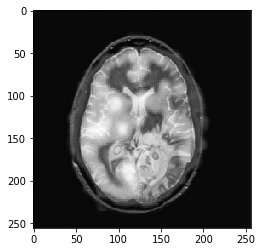

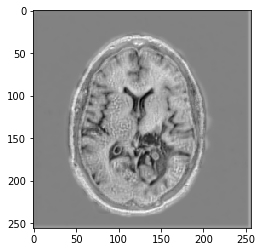

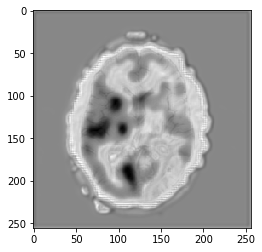

In [ ]:
#visualise fused, grad_mri and grad_pet
plt.figure(1)
plt.imshow(fused,'gray')
plt.figure(2)
plt.imshow(grad_mri,'gray')
plt.figure(3)
plt.imshow(grad_pet,'gray')
plt.show()

In [ ]:
#Stack a single MRI gradient map into three channels
grad_mri_ = np.uint8(cv2.normalize(grad_mri[0,:,:], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
grad_mri_color = np.dstack((grad_mri_, grad_mri_, grad_mri_))


In [ ]:
#Color code the PET gradient map
grad_pet_ = np.uint8(cv2.normalize(grad_pet[0,:,:], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
grad_pet_color = cv2.applyColorMap(grad_pet_, cv2.COLORMAP_JET)

In [ ]:
#convert RGB to HSV
grad_mri_hsv = color.rgb2hsv(grad_mri_color)
grad_pet_hsv = color.rgb2hsv(grad_pet_color)

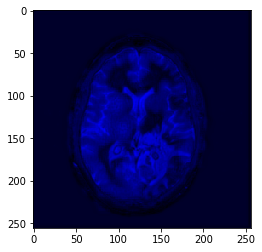

In [ ]:
#visualise the gradient MRI HSV
plt.imshow(grad_mri_hsv)

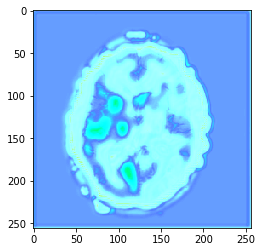

In [ ]:
#visualise the gradient PET HSV
plt.imshow(grad_pet_hsv)

In [ ]:
#Assign Hue and Saturation channels of PET gradient map to Hue and Saturation of MRI gradient map 
omega = 1
grad_mri_hsv[..., 0] = grad_pet_hsv[..., 0]
grad_mri_hsv[..., 1] = grad_pet_hsv[..., 1] * omega


In [ ]:
#Convert HSV to RGB Fused image with color coded visualisation
fused_vis = color.hsv2rgb(grad_mri_hsv)

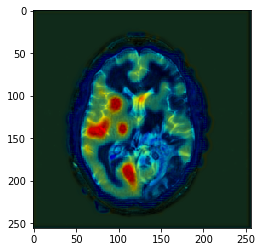

In [ ]:
plt.imshow(fused_vis)